In [1]:
from pybedtools import BedTool


In [2]:
from Bio import SeqIO


In [133]:
!awk '($4 > 0.2)' GTEX_COLON_prev_LowRes.bedGraph > GTEX_COLON_prev_LowRes_AboveT.bedGraph 


In [134]:
COAD = BedTool('TCGA_COAD_prev_LowRes.bedGraph')  # [1]
COLON = BedTool('GTEX_COLON_prev_LowRes_AboveT.bedGraph')  # [1]
Thymus = BedTool('Thymus_Prev.bedGraph')  # [1]


In [135]:
COADmS=COAD.subtract(Thymus).subtract(COLON,output='COADminusSelf.bedGraph')     

In [107]:
# Use awk to get above T

In [136]:
!awk '($4 > 0.2)' COADminusSelf.bedGraph > COADminusSelf_AboveT.bedGraph 


In [3]:
COADmSap5 = BedTool('COADminusSelf_AboveT.bedGraph')  # [1]


In [138]:
COADmSap5m=COADmSap5.merge(d=500,o="max",c=4)

In [139]:
COADmSap5ms=COADmSap5m.slop(b=75,g="hg38.chrom.sizes")

In [140]:
db=COADmSap5ms.sequence(fi="hg38.fa")

In [141]:
b = db.save_seqs('example.fa')


In [142]:
!awk 'BEGIN{FS=" "}{if(!/>/){print toupper($0)}else{print $1}}' example.fa > example2.fa

In [143]:
!orfipy example2.fa --dna orfs.fa --min 24 --partial-5 --partial-3               

orfipy version 0.0.4
Using translation table: Standard (transl_table=1) start: ['TTG', 'CTG', 'ATG'] stop: ['TAA', 'TAG', 'TGA']
Setting chunk size 682 MB. Procs 6
Logs will be saved to: orfipy_example2.fa_out/orfipy_2024_07_22_20_21_29.352091.log
Processing 13587800 bytes
Processed 12965 sequences in 1.24 seconds


In [144]:
!seqkit translate orfipy_example2.fa_out/orfs.fa > out_AAORF.fasta                  

In [81]:
# Check overlap with other database

In [4]:
genes = BedTool('hg38.knownGene.gtf.gz')    # [1]


In [5]:
genesexons = BedTool('exons.gtf')    # [1]


In [26]:
COADGeneNonExon=(COADmSap5-genesexons).intersect(genes,wb=True,u=True,output='COADGeneNonExon.bedGraph')

In [56]:
COADGeneExon=(COADmSap5).closest(genesexons).merge(c=12,output='COADGeneExon.bedGraph',o='collapse')

BEDToolsError: 
Command was:

	bedtools closest -b exons.gtf -a COADminusSelf_AboveT.bedGraph

Error message was:
Error: Sorted input specified, but the file exons.gtf has the following out of order record
chr1	knownGene	exon	30267	30667	.	+	.	gene_id "ENST00000469289.1"; transcript_id "ENST00000469289.1"; exon_number "1"; exon_id "ENST00000469289.1.1";


In [38]:
len(COADGeneExon)+len(COADGeneNonExon)+len(COADmSap5-genes)

121010

In [22]:
len(COADmSap5)

59839

In [41]:
print(COADGeneExon[1])

chr1	89850	89900	0.21845	chr1	knownGene	exon	89551	90050	.	-	.	gene_id "ENST00000495576.1"; transcript_id "ENST00000495576.1"; exon_number "2"; exon_id "ENST00000495576.1.2";



In [148]:

import argparse
import sys
import os
import pybedtools

def venn_mpl(a, b, c, colors=None, outfn="out.png", labels=None, by_length=False, dpi=300):
    """
    *a*, *b*, and *c* are filenames to BED-like files.

    *colors* is a list of matplotlib colors for the Venn diagram circles.

    *outfn* is the resulting output file.  This is passed directly to
    fig.savefig(), so you can supply extensions of .png, .pdf, or whatever your
    matplotlib installation supports.

    *labels* is a list of labels to use for each of the files; by default the
    labels are ['a','b','c']

    *by_length* if True, then instead of plotting number of intervals, plot combined
    lengths of intervals

    *dpi* is the dpi setting passed to matplotlib savefig
    """
    try:
        import matplotlib.pyplot as plt
        from matplotlib.patches import Circle
    except ImportError:
        sys.stderr.write(
            "matplotlib is required to make a Venn diagram with %s\n"
            % os.path.basename(sys.argv[0])
        )
        sys.exit(1)

    a = pybedtools.BedTool(a)
    b = pybedtools.BedTool(b)
    c = pybedtools.BedTool(c)
    count_features = lambda x:x.count()
    if by_length:
        count_features = lambda x:x.total_coverage()

    if colors is None:
        colors = ["r", "b", "g"]

    radius = 6.0
    center = 0.0
    offset = radius / 2

    if labels is None:
        labels = ["a", "b", "c"]

    circle_a = Circle(
        xy=(center - offset, center + offset),
        radius=radius,
        edgecolor=colors[0],
        label=labels[0],
    )
    circle_b = Circle(
        xy=(center + offset, center + offset),
        radius=radius,
        edgecolor=colors[1],
        label=labels[1],
    )
    circle_c = Circle(
        xy=(center, center - offset),
        radius=radius,
        edgecolor=colors[2],
        label=labels[2],
    )

    fig = plt.figure(facecolor="w")
    ax = fig.add_subplot(111)

    for circle in (circle_a, circle_b, circle_c):
        circle.set_facecolor("none")
        circle.set_linewidth(3)
        ax.add_patch(circle)

    ax.axis("tight")
    ax.axis("equal")
    ax.set_axis_off()

    kwargs = dict(horizontalalignment="center")

    # Unique to A
    ax.text(center - 2 * offset, center + offset, str(count_features(a - b - c)), **kwargs)

    # Unique to B
    ax.text(center + 2 * offset, center + offset, str(count_features(b - a - c)), **kwargs)

    # Unique to C
    ax.text(center, center - 2 * offset, str(count_features(c - a - b)), **kwargs)

    # A and B not C
    ax.text(
        center, center + 2 * offset - 0.5 * offset, str(count_features(a + b - c)), **kwargs
    )

    # A and C not B
    ax.text(
        center - 1.2 * offset, center - 0.5 * offset, str(count_features(a + c - b)), **kwargs
    )

    # B and C not A
    ax.text(
        center + 1.2 * offset, center - 0.5 * offset, str(count_features(b + c - a)), **kwargs
    )

    # all
    ax.text(center, center, str(count_features(a + b + c)), **kwargs)

    ax.legend(loc="best")

    fig.savefig(outfn, dpi=dpi)

    plt.close(fig)


def main():
    """Create a 3-way Venn diagram, using matplotlib"""
    op = argparse.ArgumentParser(description=__doc__, prog=sys.argv[0])
    op.add_argument("-a", help="File to use for the left-most circle")
    op.add_argument("-b", help="File to use for the right-most circle")
    op.add_argument("-c", help="File to use for the bottom circle")
    op.add_argument(
        "--labels",
        help="Optional comma-separated list of " "labels for a, b, and c",
        default="a,b,c",
    )
    op.add_argument(
        "--colors",
        default="r,b,g",
        help="Comma-separated list of matplotlib-valid colors "
        "for circles a, b, and c.  E.g., --colors=r,b,k",
    )
    op.add_argument(
        "-o",
        default="out.png",
        help="Output file to save as.  Extension is "
        'meaningful, e.g., out.pdf, out.png, out.svg.  Default is "%(default)s"',
    )
    op.add_argument(
        "--test", action="store_true", help="run test, overriding all other options."
    )
    options = op.parse_args()

    reqd_args = ["a", "b", "c"]
    if not options.test:
        for ra in reqd_args:
            if not getattr(options, ra):
                op.print_help()
                sys.stderr.write('Missing required arg "%s"\n' % ra)
                sys.exit(1)

    if options.test:
        pybedtools.bedtool.random.seed(1)
        a = pybedtools.example_bedtool("rmsk.hg18.chr21.small.bed")
        b = pybedtools.example_bedtool("venn.b.bed")
        c = pybedtools.example_bedtool("venn.c.bed")
        options.a = a.fn
        options.b = b.fn
        options.c = c.fn
        options.colors = "r,b,g"
        options.o = "out.png"
        options.labels = "a,b,c"

    venn_mpl(
        a=options.a,
        b=options.b,
        c=options.c,
        colors=options.colors.split(","),
        labels=options.labels.split(","),
        outfn=options.o,
    )



In [149]:
venn_mpl(db,genes,genesexons)

In [153]:
from IPython.display import Image

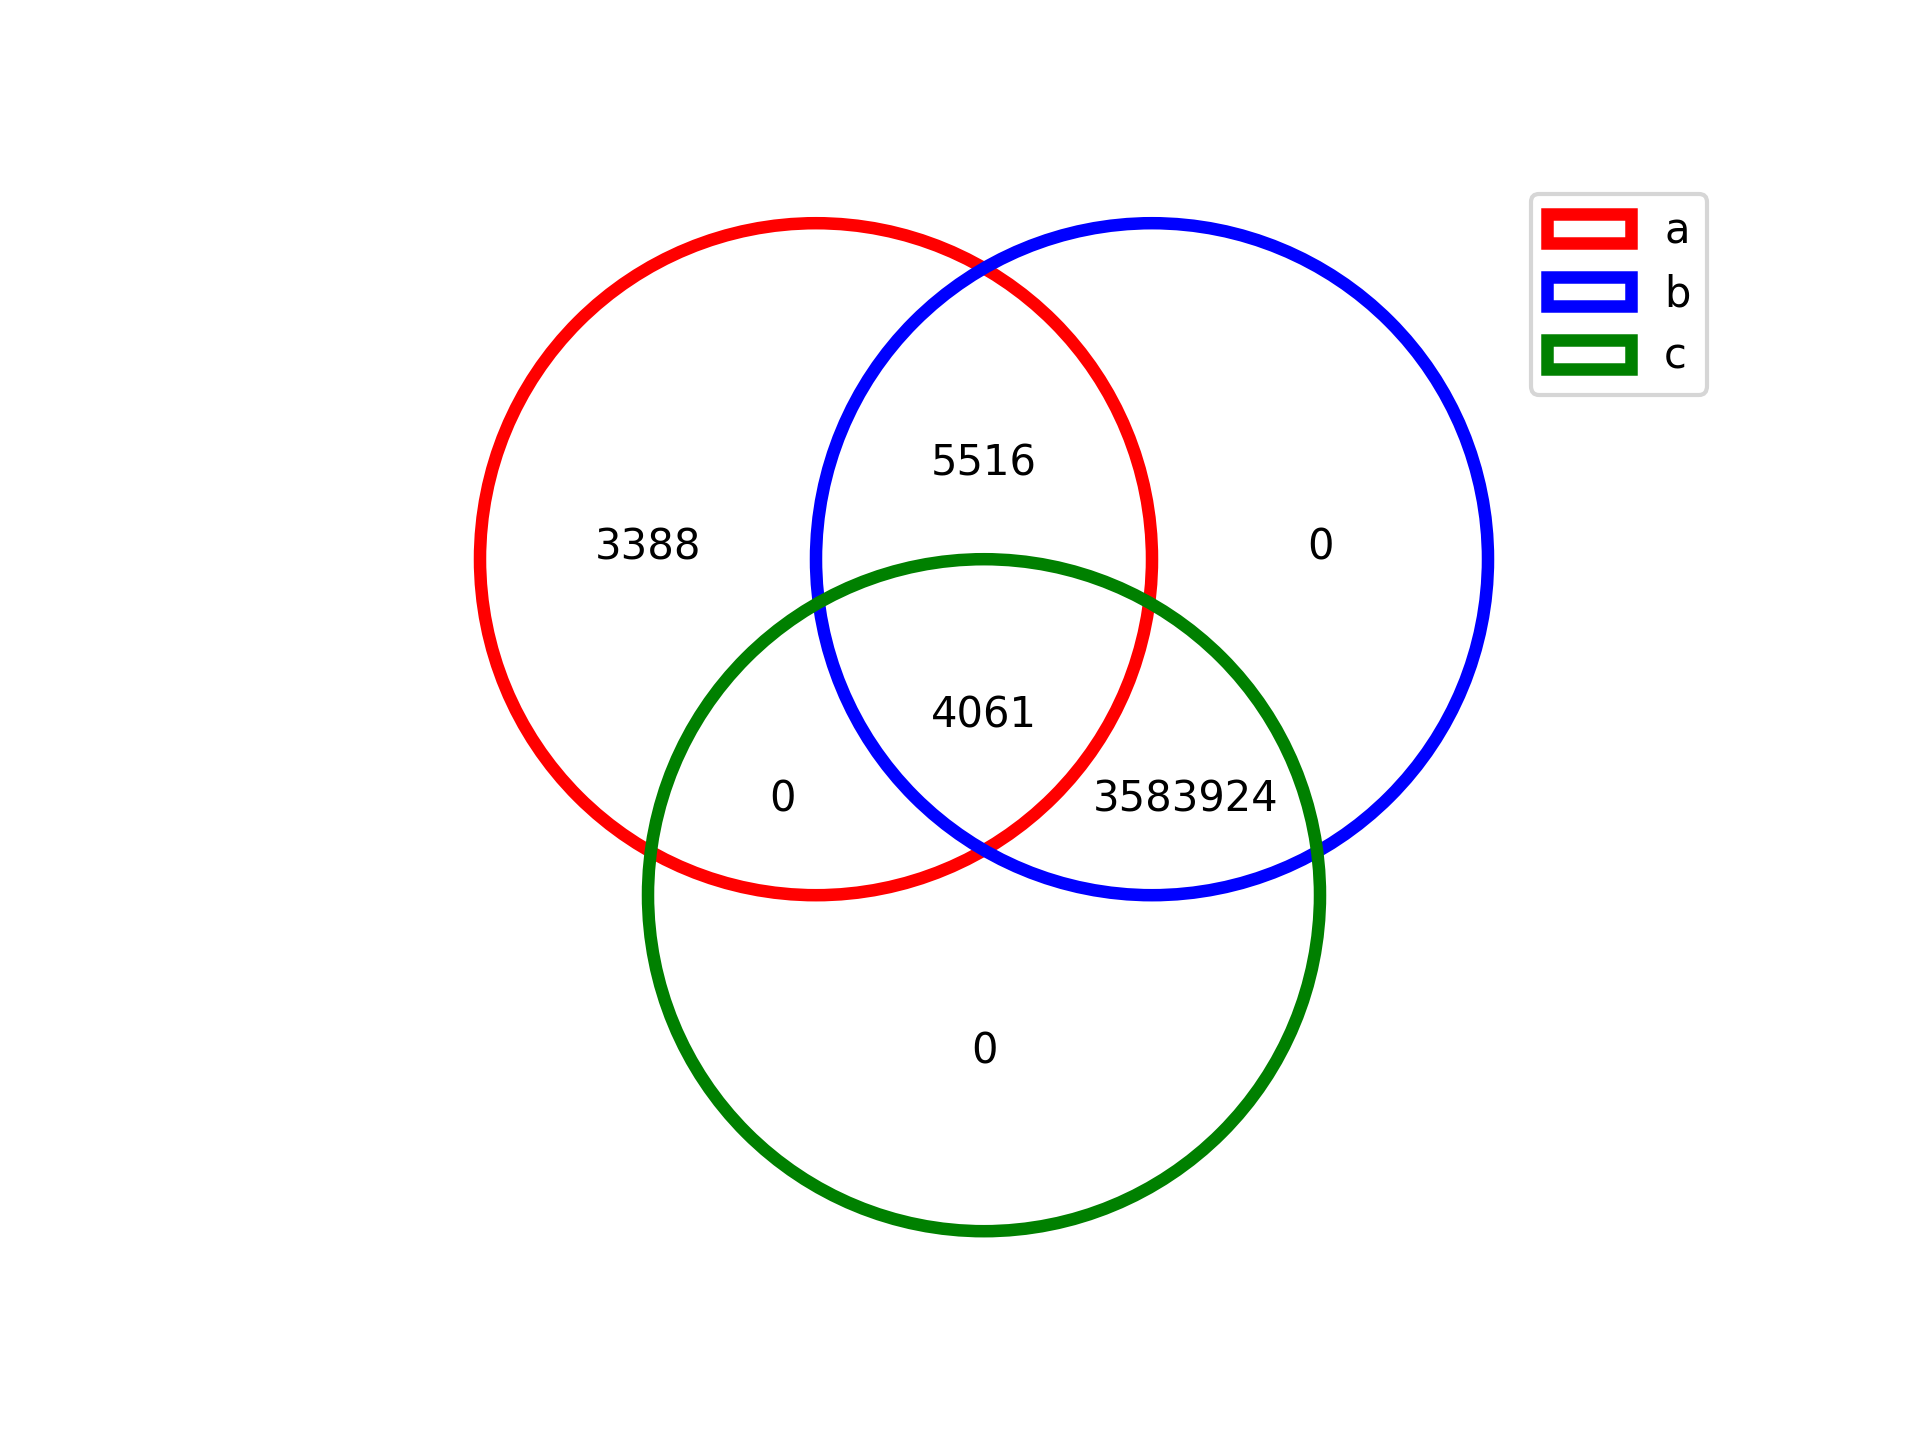

In [157]:
Image('out.png')

In [87]:
db1 = BedTool('/Users/sampalmer/Projects/RED/Bigwigs/PrevalenceBigWigs/COADminusSelfap5Merge.bedGraph')    # [1]


In [88]:
len(db1)

7823

In [119]:
len(COADmSap5ms.intersect(db1))

320

In [118]:
len(db)

22345

In [75]:
for i in range(2):
    print(genes[i])

chr1	knownGene	transcript	11869	14409	.	+	.	gene_id "ENST00000456328.2"; transcript_id "ENST00000456328.2"; 

chr1	knownGene	exon	11869	12227	.	+	.	gene_id "ENST00000456328.2"; transcript_id "ENST00000456328.2"; exon_number "1"; exon_id "ENST00000456328.2.1";



In [122]:
len(db)

22345

In [129]:
db.count()

22345

In [128]:
(db-genes).count()  # unique to a


7933

In [131]:
len(db.intersect(genes,u=True))

14412

In [132]:
7933+14412

22345

In [40]:
!awk '$3 == "exon"' hg38.knownGene.gtf > exons.gtf

In [71]:
!awk '$3 == "transcript"' hg38.knownGene.gtf > introns.gtf

In [49]:
!awk '$3 == "CDS"' hg38.knownGene.gtf > CDS.gtf

In [80]:
!awk '$9~/CCAT/' hg38.knownGene.gtf > Linc.gtf

In [65]:
genesCDS = BedTool('CDS.gtf')    # [1]


In [41]:
genesexons = BedTool('exons.gtf')    # [1]


In [72]:
genesintrons = BedTool('introns.gtf')    # [1]


In [73]:
len(db.intersect(genesintrons))

69

In [123]:
len(db.intersect(genesexons))

6799

In [124]:
len(db.intersect(genesCDS))

1288

In [74]:
len(genesexons.intersect(genesCDS))

12180067

In [125]:
len(genesexons)

1769117

In [130]:
(db-genesexons).count()

19738